In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly_resampler import FigureResampler, FigureWidgetResampler
from funcs import fit_ar_garch, reconstruct_residuals, get_imbalance_price, fit_sample_copula
from copulas.univariate import GaussianKDE, BetaUnivariate
from fetch_da_prices import load_and_process_boiler_data, get_day_ahead_prices
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
start = pd.Timestamp('20250304', tz='UTC')
end = pd.Timestamp('20250504', tz='UTC')

In [5]:
capacity_up_hat = pd.read_parquet('/home/alqua/git/afrr-price-forecast-engine/data/results/afrr_price_forecast_UP.parquet')
da_prices_hat = load_and_process_boiler_data("/home/alqua/data/boiler_data/daily_data")

da_prices = get_day_ahead_prices(start, end, price_area="DK_1")
da_prices_hat = da_prices_hat.loc[start:end]
pic_prices = get_imbalance_price(start_date=start, end_date=end, price_area="DK1")
capacity_up_hat.index = capacity_up_hat.index.tz_localize('UTC')
pic_prices.index = pic_prices.index.rename('time_utc')

pic_prices.index= pd.to_datetime(pic_prices.index, utc=True)
capacity_up_hat = capacity_up_hat.loc[start:end]

In [ ]:
da_prices_df = da_prices_hat.join(da_prices, on="time_utc")
da_prices_df["da_price"] = da_prices_df["da_price"].ffill()
da_prices_df["da_resid"] = da_prices_df["da_preds"] - da_prices_df["da_price"]


In [16]:
data = pic_prices.join(capacity_up_hat, on='time_utc' )
data = pic_prices.join(capacity_up_hat, on='time_utc' )
data['pic_up_resid'] = data['SpotPriceEUR'] - data['aFRRVWAUpEUR']
data = data.dropna()


In [22]:
data = data.join(da_prices_df, on='time_utc', how='inner')

In [ ]:
ar_params_cap_up, garch_params_cap_up, std_res_cap_up, cond_vol_up = fit_ar_garch(data['cap_up_resid'], ar_order=1, garch_p=1, garch_q=1)
ar_params_pic_up, garch_params_pic_up, std_res_cap_pic_up, cond_vol_pic_up = fit_ar_garch(data['pic_up_resid'], ar_order=1, garch_p=1, garch_q=1)
ar_params_da, garch_params_da, std_res_da, cond_vol_da = fit_ar_garch(data['da_resid'], ar_order=1, garch_p=1, garch_q=1)

data['cap_up_resid_std'] = std_res_cap_up
data['pic_up_resid_std'] = std_res_cap_pic_up
data['da_resid_std'] = std_res_cap_pic_up

/home/alqua/anaconda3/envs/opt_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alqua/anaconda3/envs/opt_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alqua/anaconda3/envs/opt_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alqua/anaconda3/envs/opt_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated freq

In [34]:
res_df = fit_sample_copula(residual_df=data,
                           columns=["cap_up_resid_std", "pic_up_resid_std", "da_resid_std"],
                           distribution={"cap_up_resid_std": GaussianKDE, 
                                         "pic_up_resid_std": GaussianKDE, 
                                         "da_resid_std": BetaUnivariate},
                           return_df=False)

/home/alqua/anaconda3/envs/opt_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/alqua/anaconda3/envs/opt_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:800: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


In [25]:
res_df['cap_up_resid_std_cop_trans'] = reconstruct_residuals(
                                            res_df['cap_up_resid_std_cop'], 
                                            ar_params_cap_up, 
                                            garch_params_cap_up, 
                                            initial_variance=0.1)

res_df['pic_up_resid_std_cop_trans'] = reconstruct_residuals(
                                            res_df['pic_up_resid_std_cop'], 
                                            ar_params_pic_up, 
                                            garch_params_pic_up, 
                                            initial_variance=0.1)

res_df['da_resid_std_cop_trans'] = reconstruct_residuals(
                                            res_df['da_resid_std_cop'], 
                                            ar_params_da, 
                                            garch_params_da, 
                                            initial_variance=0.1)

/home/alqua/git/afrr-price-forecast-engine/data_collection_module/funcs.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  garch_residuals[0] = std_residuals[0] * np.sqrt(variances[0])
/home/alqua/git/afrr-price-forecast-engine/data_collection_module/funcs.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  garch_residuals[t] = std_residuals[t] * np.sqrt(variances[t])


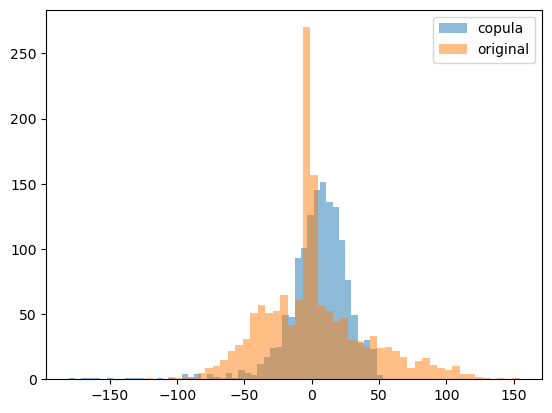

In [30]:
_ = plt.hist(res_df['da_resid_std_cop_trans'], bins=50, alpha=0.5, label='copula')
_ = plt.hist(res_df['da_resid'], bins=50, alpha=0.5, label='original')
plt.legend()

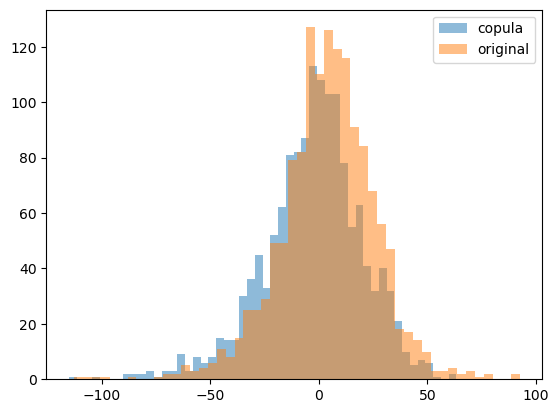

In [32]:
_ = plt.hist(res_df['cap_up_resid_std_cop_trans'], bins=50, alpha=0.5, label='copula')
_ = plt.hist(res_df['cap_up_resid'], bins=50, alpha=0.5, label='original')
plt.legend()

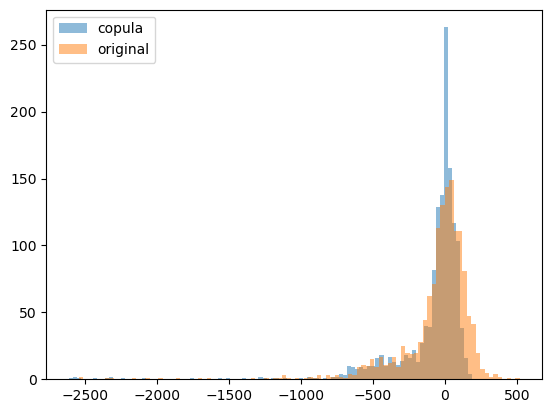

In [41]:
_ = plt.hist(res_df['pic_up_resid'], bins=100, alpha=0.5, label='copula')
_ = plt.hist(res_df['pic_up_resid_std_cop_trans']-70, bins=100, alpha=0.5, label='original')
plt.legend()